<a href="https://colab.research.google.com/github/davidwhogg/Sailing/blob/main/ipynb/sailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anisotropic ram-pressure sailing model

## to-do items:
- Plot things in the air rest frame too.
- Label the plots with the direction cosines.
- Make the boat glyph something with a direction (a grey triangle, say).
- Make sure code clearly breaks degeneracies between `theta_s` and `theta_s - np.pi`
- *Enhanced Goal:* Make the optimal route-planning actually work?

In [1]:
import numpy as np
import pylab as plt
import scipy.optimize as op
np.random.seed(17)
figunit = 2.5 # some units

In [2]:
# create objects to hold the state of the world and the properties of the boat

def ehats(theta):
    """
    Wastey-time reshapes to be paranoid.
    """
    ct = np.cos(theta)
    st = np.sin(theta)
    return np.array([ct, st]).reshape(2), np.array([-st, ct]).reshape(2)

class World():
    
    def __init__(self, vwater, vair):
        self.rho_water = 1.0 # kg / m^3
        self.rho_air = 0.0014 # kg / m^3
        self.vwater = vwater
        assert self.vwater.shape == (2, )
        self.vair = vair
        assert self.vair.shape == (2, )

class Boat():
    
    def __init__(self):
        self.A_perp_k = 1.0 # m^2
        self.A_perp_s = self.A_perp_k / 0.0014 # seems like sensible design
        self.A_par_k = 0.005 * self.A_perp_k # very optimistic
        self.A_par_s = 0.005 * self.A_perp_s # very optimistic


In [3]:
# create the world and the boat

world = World(np.zeros(2), np.array([8., 0.])) # water and air velocities
boat = Boat()

In [4]:
# force

def _force(rho, A, e, dv):
    edv = e @ dv
    return rho * A * (edv) ** 2 * np.sign(edv) * e, \
      -2 * rho * A * (edv) * np.sign(edv) * np.outer(e, e)

def force(vboat, theta_s, theta_k, boat, world):
    """
    Compute the net force on a moving boat.
    """
    rhoa = world.rho_air
    rhow = world.rho_water
    e_perp_s, e_par_s = ehats(theta_s)
    e_perp_k, e_par_k = ehats(theta_k)
    faperp, dfadvperp = _force(rhoa, boat.A_perp_s, e_perp_s, world.vair - vboat)
    fapar,  dfadvpar  = _force(rhoa, boat.A_par_s,  e_par_s,  world.vair - vboat)
    fa, dfadv = faperp + fapar, dfadvperp + dfadvpar
    fwperp, dfwdvperp = _force(rhow, boat.A_perp_k, e_perp_k, world.vwater - vboat)
    fwpar,  dfwdvpar  = _force(rhow, boat.A_par_k,  e_par_k,  world.vwater - vboat)
    fw, dfwdv = fwperp + fwpar, dfwdvperp + dfwdvpar
    return fa + fw, dfadv + dfwdv

In [5]:
# use Newton's method to find the steady state

def get_vboat(theta_s, theta_k, boat, world, maxiter=128, rcond=1.e-6):
    """
    Use Newton's method to find the steady-state boat velocity.
    """
    vb = 0.5 * (world.vair + world.vwater) # trust me
    ff, dfdv = force(vb, theta_s, theta_k, boat, world)
    iter = 0
    while (ff @ ff) > 1.e-10 and iter < maxiter:
        # print(iter, vb, ff, dfdv, np.linalg.lstsq(dfdv, ff, rcond=rcond)[0])
        vb -= np.linalg.lstsq(dfdv, ff, rcond=rcond)[0]
        ff, dfdv = force(vb, theta_s, theta_k, boat, world)
        iter += 1
    if iter >= maxiter:
        print("get_vboat(): WARNING: Terminated on maxiter.")
        print(iter, vb, ff, dfdv, np.linalg.eigvalsh(dfdv))
    return vb

In [6]:
# viz

def hogg_arrow(ax, base, vector, c="k", lw=2, alpha=1., headlen=1.5):
    """
    This code exists because matplotlib has arrow issues that I can't abide.
    """
    vmag = np.linalg.norm(vector)
    thislen = vmag
    if vmag > headlen:
        thislen = headlen
    tipangle = 0.2 # rad
    ct, st = np.cos(tipangle), np.sin(tipangle)
    R = np.array([[ct, st], [-st, ct]])
    ltip = R @ vector * thislen / vmag
    rtip = R.T @ vector * thislen / vmag
    ax.plot([base[0], base[0] + vector[0], base[0] + vector[0] - ltip[0]],
            [base[1], base[1] + vector[1], base[1] + vector[1] - ltip[1]],
            color=c, ls="-", lw=lw, alpha=alpha)
    ax.plot([base[0] + vector[0], base[0] + vector[0] - rtip[0]],
            [base[1] + vector[1], base[1] + vector[1] - rtip[1]],
            color=c, ls="-", lw=lw, alpha=alpha)

def plot_boat(theta_s, theta_k, boat, world, ax=None, rdest=None):
    """
    This code is filled with hard-coded parameters; brittle.
    ONLY WORKS in the water rest frame right now.
    """
    if ax is None:
        f = plt.figure(figsize=(1.2 * figunit, 1.2 * figunit))
        ax = plt.gca()
    vb = get_vboat(theta_s, theta_k, boat, world)

    # set rest frame and plot the world
    restframe = "water rest frame"
    foo = 16.
    ax.text(-foo, -foo, restframe)
    vair = world.vair - world.vwater
    vb = vb - world.vwater
    hogg_arrow(ax, np.array([-foo, 0.]), vair)
    ax.text(-foo, 1., "wind")
    if rdest is not None:
        rd = rdest * 2. * foo / np.linalg.norm(rdest)
        ax.plot([0., rd[0]], [0., rd[1]], "k--", lw=1, alpha=0.5)

    # plot the boat
    seigv = ehats(theta_s)[1]
    sw = 8.
    ax.plot([-sw * seigv[0], sw * seigv[0]], [-sw * seigv[1], sw * seigv[1]], "k-", lw=1.)
    keigv = ehats(theta_k)[1]
    kw = 4.
    ax.plot([-kw * keigv[0], kw * keigv[0]], [-kw * keigv[1], kw * keigv[1]], "k-", lw=6., alpha=0.2)
    hogg_arrow(ax, [0., 0.], vb)
    ax.set_xlim(-foo - 1., foo + 1.)
    ax.set_ylim(-foo - 1., foo + 1.)
    ax.set_aspect("equal")

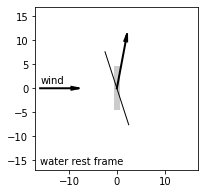

In [7]:
# check the plotting code
theta_k = 0. * np.pi
theta_s = 0.1 * np.pi
plot_boat(theta_s, theta_k, boat, world)

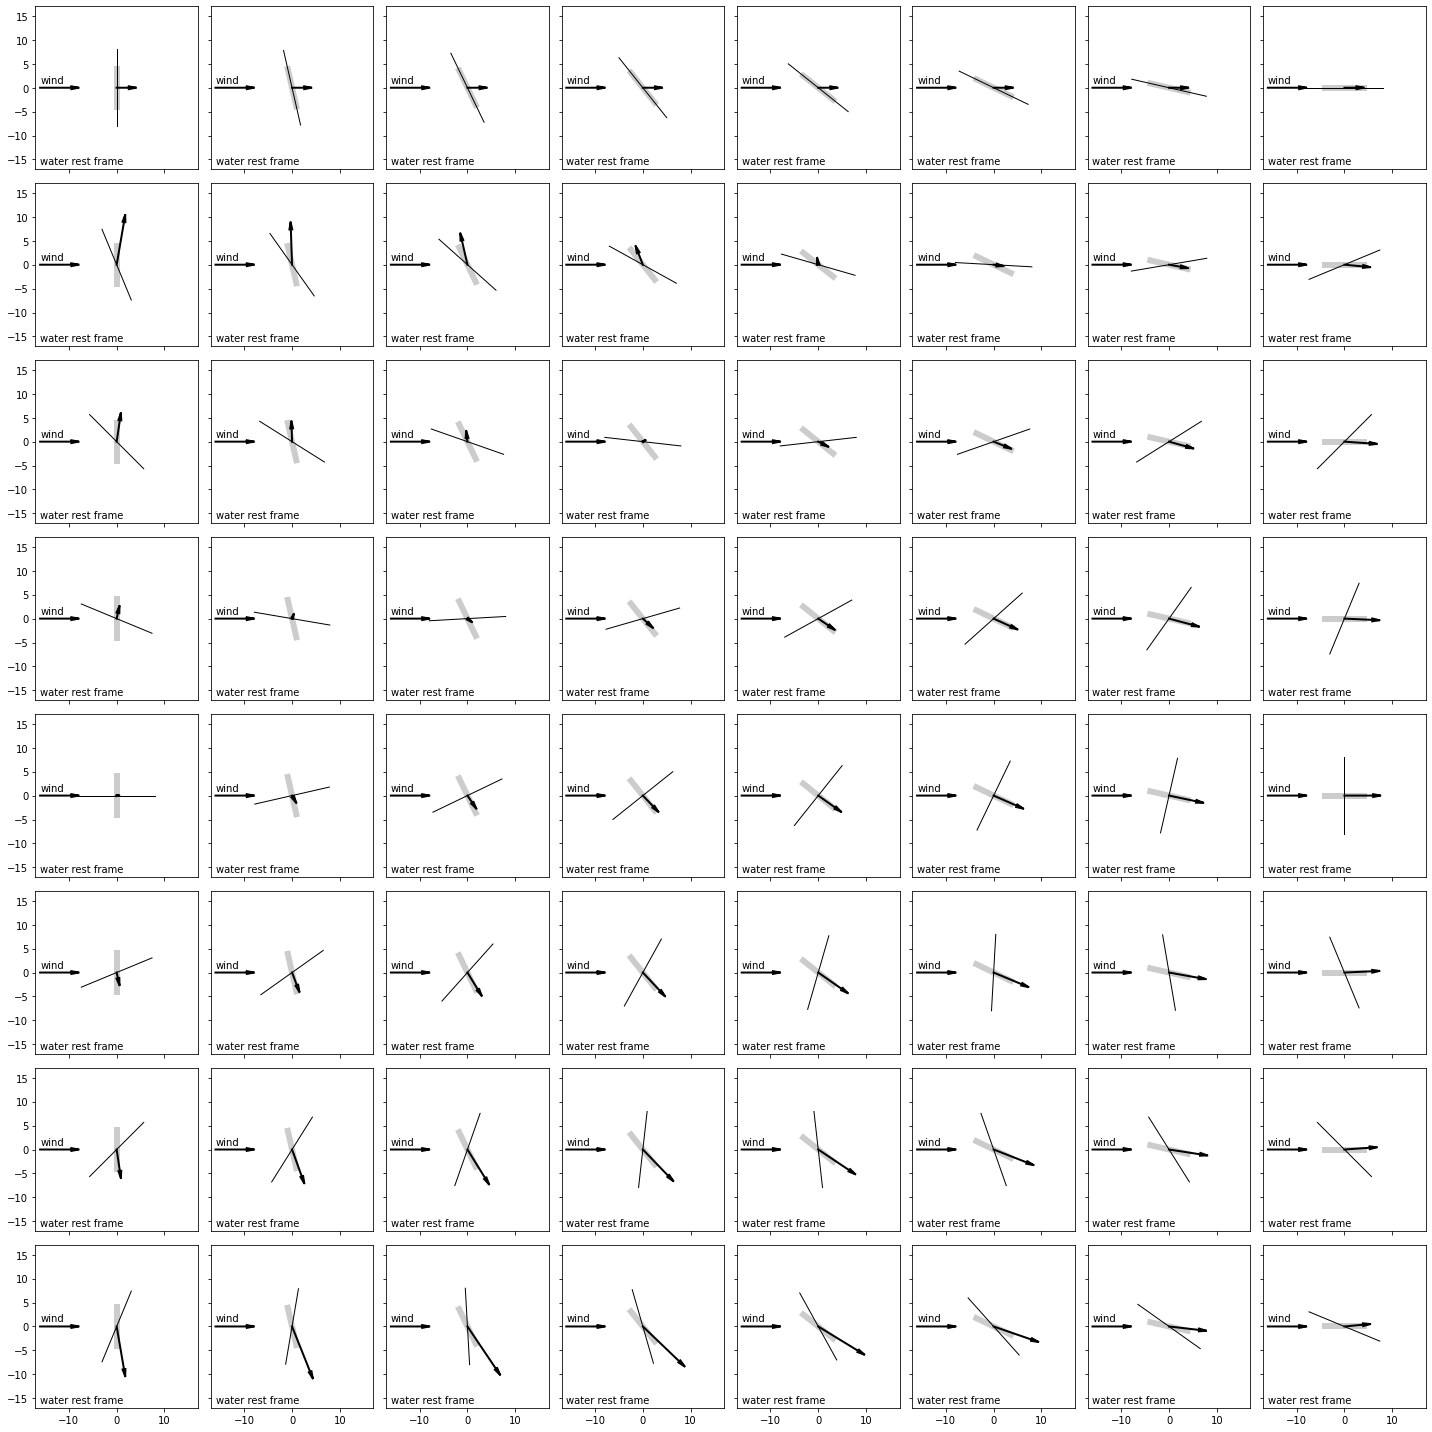

In [8]:
# a grid of cases
n1, n2 = 8, 8
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)

for i in range(n1):
  for j in range(n2):
    theta_k = j * 0.5 * np.pi / (n2 - 1)
    theta_s = i * 1.0 * np.pi / n1 + np.pi + theta_k
    plot_boat(theta_s, theta_k, boat, world, ax=axes[i, j])

In [9]:
# time for Good Sailing (tm):

def sail_good(theta_k, boat, world):
    """
    Find the best theta_s given a theta_k:
    - Start with a grid search.
    - Then optimize with (gasp) Nelder-Mead.
    """
    def objective(theta_s):
        e_k_par = ehats(theta_k)[1]
        return -e_k_par @ (get_vboat(theta_s, theta_k, boat, world) - world.vwater)
    ngrid = 16
    theta_ss = np.arange(0.5 * np.pi / ngrid, np.pi, np.pi / ngrid)
    obs = [objective(ts) for ts in theta_ss]
    theta_s0 = theta_ss[np.argmin(obs)]
    # plt.plot(theta_ss, obs, "ko")
    # print(theta_s0)
    res = op.minimize(objective, theta_s0, method="Nelder-Mead")
    if not res.success:
        print(res)
        assert False
    return res.x[0]

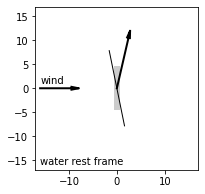

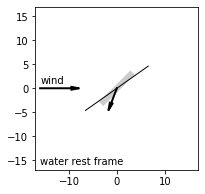

In [10]:
# test sail_good()
theta_k = 0.
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)
theta_k = 0.75 * np.pi
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)

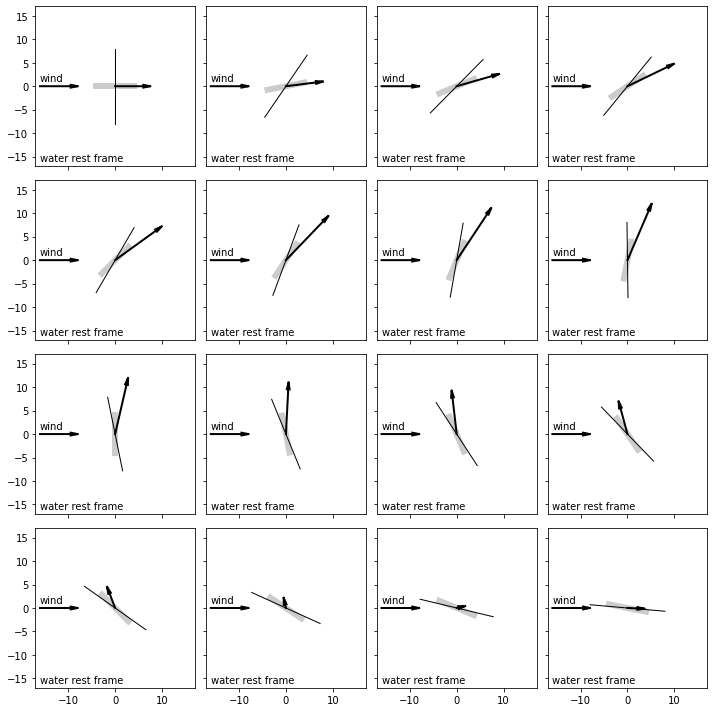

In [11]:
# a grid of cases
n1, n2 = 4, 4
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)
axes = axes.flatten()

k = 0
for i in range(n1):
    for j in range(n2):
        theta_k = k * np.pi / (n1 * n2) - 0.5 * np.pi
        theta_s = sail_good(theta_k, boat, world)
        plot_boat(theta_s, theta_k, boat, world, ax=axes[k])
        k += 1

In [12]:
# time for Best Sailing (tm):

def sail_best(rdest, vdest, boat, world):
    """
    Find the best theta_s, theta_k given a destination.
    - Start with a grid of Good Sailing (tm) tests.
    - Then optimize again with (gasp) Nelder-Mead.
    
    ## inputs:
    - `rdest`: vector displacement to destination
    - `vdest`: velocity of the destination (usually zero, but hey)
    - `boat`: `Boat()` object
    - `world`: `World()` object
    """
    # define objective
    edest = rdest / np.linalg.norm(rdest)
    def objective(pars):
        theta_s, theta_k = pars
        return -edest @ (get_vboat(theta_s, theta_k, boat, world) - vdest)
    # initialize by looking at a grid of Good(tm) options.
    theta_k0 = np.arctan2(edest[1], edest[0]) - 0.5 * np.pi
    theta_ks = np.linspace(theta_k0 - 0.125 * np.pi, theta_k0 + 0.125 * np.pi, 16)
    parss = [(sail_good(theta_k, boat, world), theta_k) for theta_k in theta_ks]
    objs = [objective(pars) for pars in parss]
    pars0 = parss[np.argmin(objs)]
    # optimize
    res = op.minimize(objective, pars0, method="Nelder-Mead")
    if not res.success:
        print(res)
        assert False
    return res.x

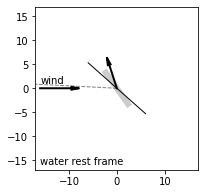

In [13]:
# test sail_best()
rdest = np.array([-1000., 50.])
vdest = np.zeros(2)
best_theta_s, best_theta_k = sail_best(rdest, vdest, boat, world)
plot_boat(best_theta_s, best_theta_k, boat, world, rdest=rdest)

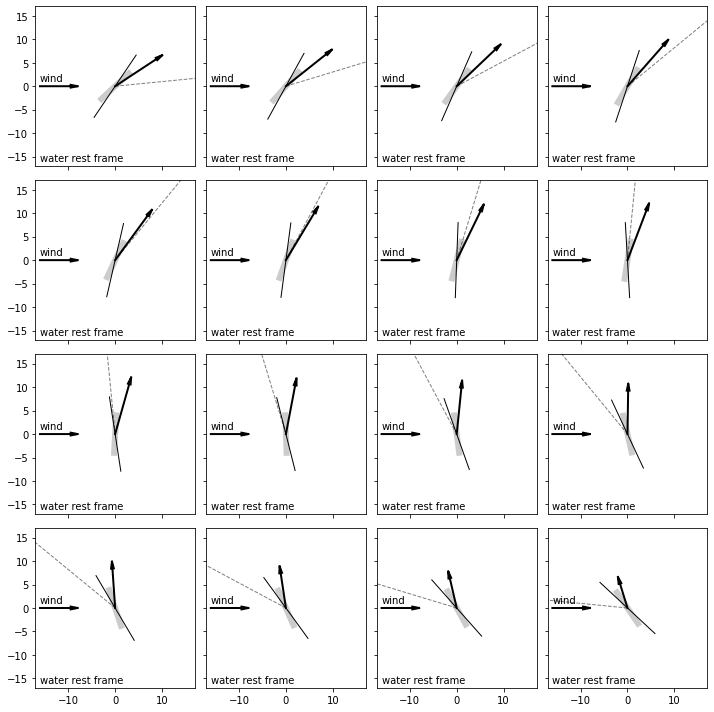

In [14]:
# a grid of cases
n1, n2 = 4, 4
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)
axes = axes.flatten()

k = 0
for i in range(n1):
    for j in range(n2):
        theta_d = k * np.pi / (n1 * n2) + 0.5 * np.pi / (n1 * n2)
        rdest = 1000. * ehats(theta_d)[0]
        theta_s, theta_k = sail_best(rdest, np.zeros(2), boat, world)
        plot_boat(theta_s, theta_k, boat, world, ax=axes[k], rdest=rdest)
        k += 1

In [15]:
# now do a very large number of trials:

ntrials = 2048
vbs_random = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_s, theta_k = 2. * np.pi * np.random.uniform(size=(2))
    vb = get_vboat(theta_s, theta_k, boat, world)
    vbs_random[trial] = vb

ntrials = 256
vavbmax, vavbmin = 0., 0.
vbs_good = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_k = 2. * np.pi * np.random.uniform()
    theta_s_good = sail_good(theta_k, boat, world)
    vb = get_vboat(theta_s_good, theta_k, boat, world)
    vbs_good[trial] = vb
    if world.vair @ vb > vavbmax:
        vavbmax = world.vair @ vb
        downwind = (theta_s_good, theta_k)
    if world.vair @ vb < vavbmin:
        vavbmin = world.vair @ vb
        upwind = (theta_s_good, theta_k)

ntrials = 128
vbs_best = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta = 2. * np.pi * np.random.uniform()
    rdest = 1000. * ehats(theta)[0]
    theta_s_best, theta_k_best = sail_best(rdest, np.zeros(2), boat, world)
    vb = get_vboat(theta_s_best, theta_k_best, boat, world)
    vbs_best[trial] = vb

(-16.0, 16.0)

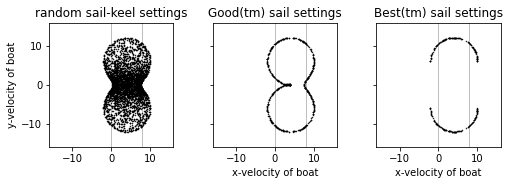

In [16]:
# plot the hourglass

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(3 * figunit, 1 * figunit), tight_layout=True)
foo = np.linalg.norm(world.vair - world.vwater)

for ax in axes:
    ax.axvline(world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    ax.axvline(0., color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    ax.set_xlim(-2 * foo, 2 * foo)
    ax.set_ylim(-2 * foo, 2 * foo)
    ax.set_aspect("equal")

ax = axes[0]
ax.set_title("random sail-keel settings")
ax.plot(vbs_random[:, 0], vbs_random[:, 1], "k.", ms=1)
ax.plot(vbs_random[:, 0], -vbs_random[:, 1], "k.", ms=1) # WARNING: BRITTLE
ax.set_ylabel("y-velocity of boat")

ax = axes[1]
ax.set_title("Good(tm) sail settings")
ax.plot(vbs_good[:, 0], vbs_good[:, 1], "k.", ms=1)
ax.plot(vbs_good[:, 0], -vbs_good[:, 1], "k.", ms=1)
ax.set_xlabel("x-velocity of boat")

ax = axes[2]
ax.set_title("Best(tm) sail settings")
ax.plot(vbs_best[:, 0], vbs_best[:, 1], "k.", ms=1)
ax.plot(vbs_best[:, 0], -vbs_best[:, 1], "k.", ms=1)
ax.set_xlabel("x-velocity of boat")

ax.set_xlim(-2 * foo, 2 * foo)
ax.set_ylim(-2 * foo, 2 * foo)

In [17]:
# now plot a course from A to B
# HOGG: WRONG: Doesn't penalize tacking!

def make_course(r_A, r_B, boat, world, dt = 1.0):
    bar = (r_B - r_A) @ (r_B - r_A)
    rr = 1. * r_A
    rrs = [rr, ]
    r_AB = r_B - rr
    while (rr - r_A) @ (r_B - r_A) < bar:
        best = sail_best(r_AB, np.zeros(2), boat, world)
        vb = get_vboat(*best, boat, world)
        rr = rr + vb * dt
        r_AB = r_B - rr
        rrs.append(rr)
    return np.array(rrs)

In [18]:
rA = np.array([0., 0.])
rB = np.array([-100., 100.])
rrs = make_course(rA, rB, boat, world)

(55, 2)


Text(0.5, 1.0, 'this plot is wrong')

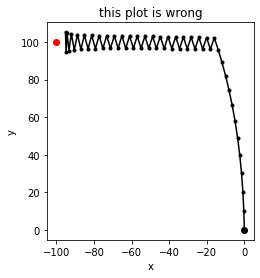

In [19]:
print(rrs.shape)
plt.plot([rA[0],], [rA[1],], "ko")
plt.plot([rB[0],], [rB[1],], "ro")
plt.plot(rrs[:,0], rrs[:,1], "k-")
plt.plot(rrs[:,0], rrs[:,1], "k.")
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("this plot is wrong")